# Detecting Crashes in the Price of Oil Futures using TDA

## Load libraries

In [2]:
# Data source
import yfinance as yf

# Data wrangling
import numpy as np
import pandas as pd

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
from plotting import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# TDA magic
import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.plotting import plot_diagram, plot_point_cloud
from gtda.pipeline import Pipeline

## Load and explore Oil Futurestime series

Here we use the `yfinance` library to download historical market data from Yahoo! Finance.

In [3]:
Oil = yf.Ticker("CL=F")
Oil_df = Oil.history(period="max")
Oil_df.head()

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2000-08-23  31.950001  32.799999  31.950001  32.049999   79385          0   
2000-08-24  31.900000  32.240002  31.400000  31.629999   72978          0   
2000-08-25  31.700001  32.099998  31.320000  32.049999   44601          0   
2000-08-28  32.040001  32.919998  31.860001  32.869999   46770          0   
2000-08-29  32.820000  33.029999  32.560001  32.720001   49131          0   

            Stock Splits  
Date                      
2000-08-23             0  
2000-08-24             0  
2000-08-25             0  
2000-08-28             0  
2000-08-29             0

In [4]:
Oil_df.shape

(5347, 7)

We are interested in the `Close` price values, so let's take a look at the complete time series:

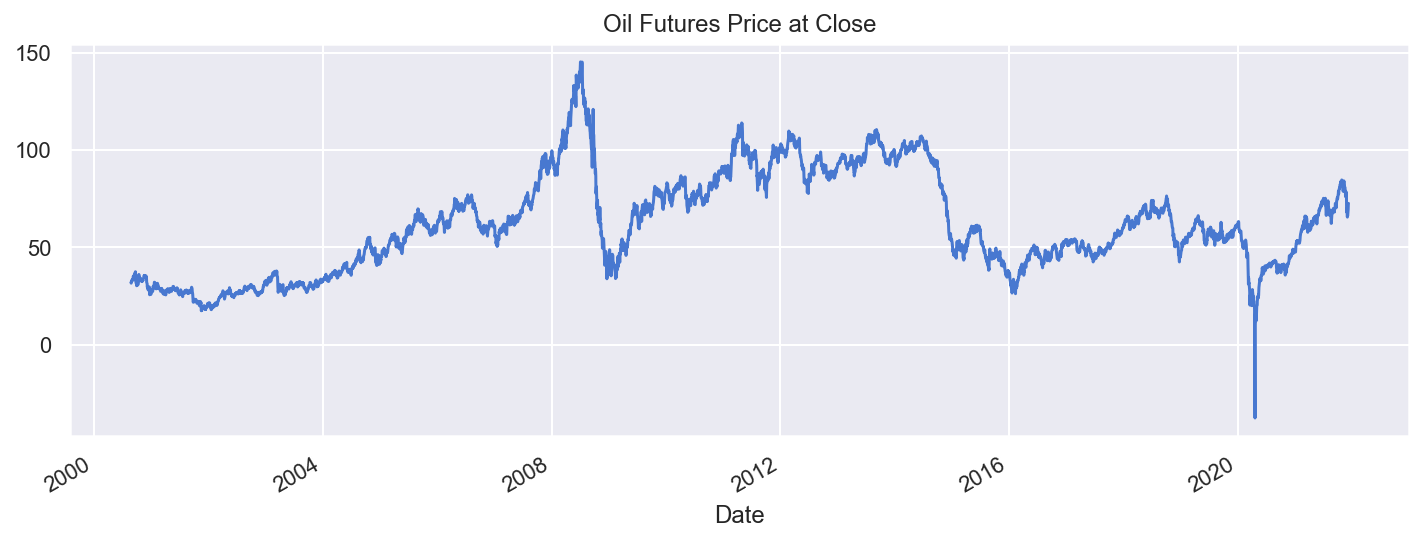

In [5]:
price_df = Oil_df['Close']
price_df.plot()
plt.title('Oil Futures Price at Close')
plt.show()

## Resampling

In [6]:
start_year = '2015'
stop_year = '2019'
# use pad to replace missing values by last non-missing value
# oil futures are not restricted to standard trading hours

price_resampled_df = price_df.resample('48H').pad()[start_year:stop_year]
price_resampled_df.tail()

Date
2019-12-22    60.439999
2019-12-24    61.110001
2019-12-26    61.680000
2019-12-28    61.720001
2019-12-30    61.680000
Freq: 48H, Name: Close, dtype: float64

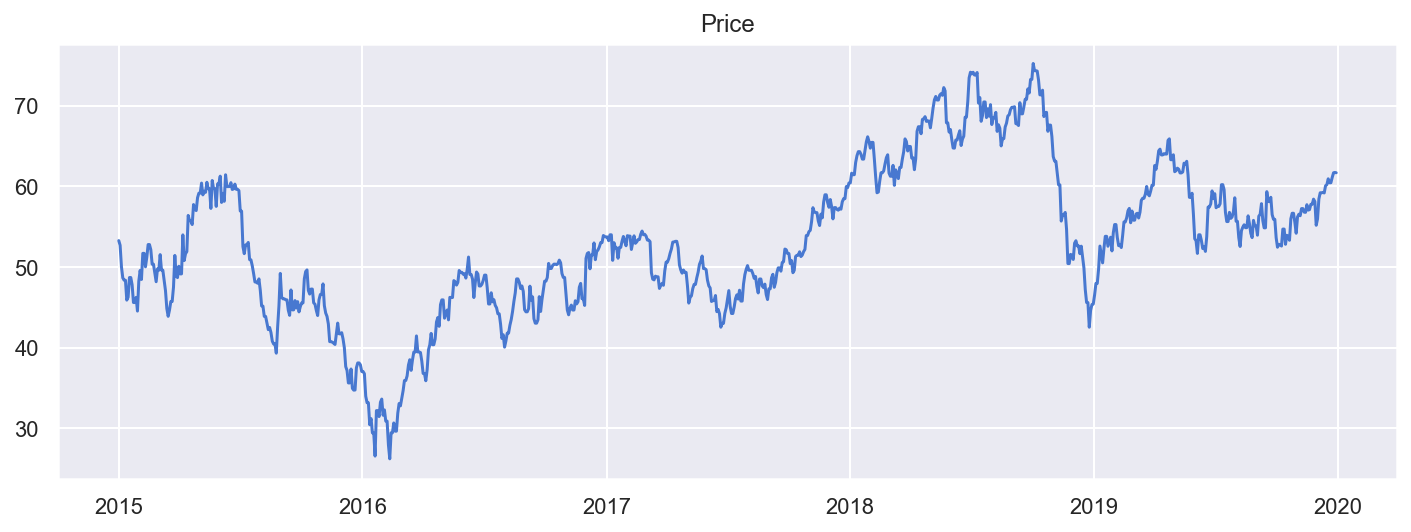

In [7]:
plt.plot(price_resampled_df)
plt.title('Price')
plt.show()

## Time series as point clouds -- Takens' embedding

Discrete time series – that is, time series indexed by a sequence of times $t_0, t_1, \ldots$ – are typically visualised as scatter plots in two dimensions. Points in the plot have times $t_i$ as their horizontal co-ordinates, and the corresponding values $y(t_i)$ of the variable of interest, $y$, as their vertical co-ordinates.

This representation makes the **_local_** behaviour of the time series easy to track by scanning the plot from left to right. But it is often ineffective at conveying important effects which may be occurring over larger time scales.

Here we want to present a different way of encoding a time-evolving process. It is based on the idea that some key properties of the dynamics can be unveiled very effectively in higher dimensions. We will be able to represent a univariate time series as a **_point cloud_**, i.e. a set of vectors in a Euclidean space of arbitrary dimension.

The procedure works as follows: we pick two integers $d$ and $\tau$. For each time $t_i \in (t_0, t_1, \ldots )$, we collect the values of the variable $y$ at $d$ distinct times, evenly spaced by $\tau$ and starting at $t_i$, and present them as a vector with $d$ entries, namely $Y_{t_i} = (y_{t_i}, y_{t_i + \tau}, \ldots , y_{t_i + (d-1)\tau})$. The result is a set of vectors in $d$-dimensional space! $\tau$ is called the **_time delay_** parameter, and $d$ the **_embedding dimension_**.

This **_time-delay embedding_** technique is also called **_Takens' embedding_** after Floris Takens, who demonstrated its significance with a celebrated [theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem) in the context of *nonlinear* dynamical systems.

The **_outer window_** allows us to apply Takens embedding locally on a certain interval rather than over the whole time series. The result of this procedure is therefore a time series of point clouds with possibly interesting topologies.

In [8]:
embedding_dimension = 3
embedding_time_delay = 2

In [9]:
embedder = ts.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

In [10]:
price_values = price_resampled_df.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

In [11]:
window_size = 20
window_stride = 5

In [12]:
sliding_window = ts.SlidingWindow(size=window_size, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

In [13]:
window_num = 42
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

## A simple baseline
Here we create a simple baseline that tracks the first derivative of our time series over a sliding window. By using the `SlidingWindow` class from `giotto-learn` we can quickly obtain arrays that are amenable for the `scikit-learn` APIs:

In [14]:
window_size_price = window_size + embedder_dimension * embedder_time_delay - 2
sliding_window_price = ts.SlidingWindow(size=window_size_price, stride=window_stride)
window_indices = sliding_window_price.slice_windows(price_values)
price_windows = sliding_window_price.fit_transform(price_values)

In [15]:
abs_derivative_of_means = np.abs(np.mean(np.diff(price_windows, axis=0), axis=1))

In [16]:
# define time index to combine with numpy arrays
indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = price_resampled_df.iloc[indices].index

In [17]:
resampled_close_price_derivs = price_resampled_df.loc[time_index_derivs]

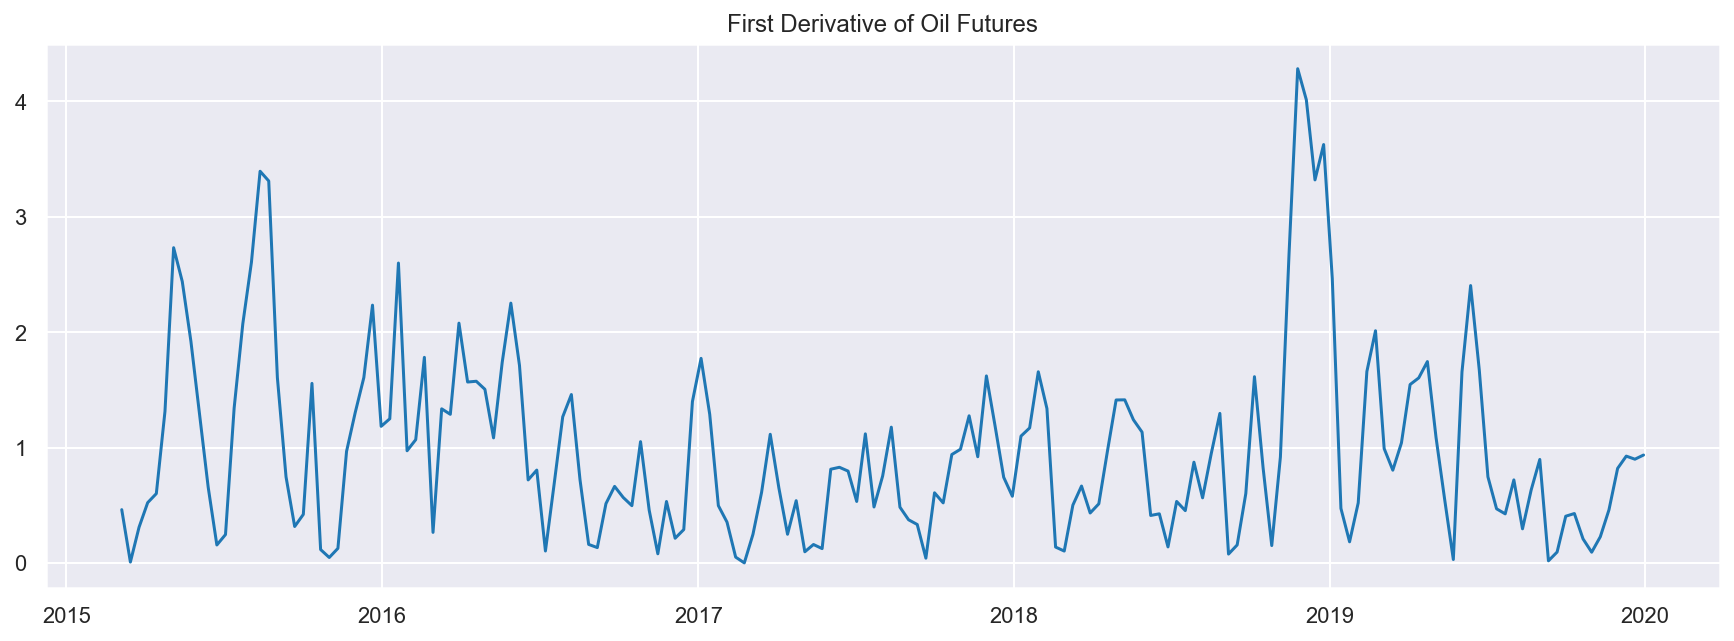

In [18]:
plt.figure(figsize=(15,5))
plt.plot(time_index_derivs, abs_derivative_of_means, color='#1f77b4')
plt.title('First Derivative of Oil Futures')
plt.show()

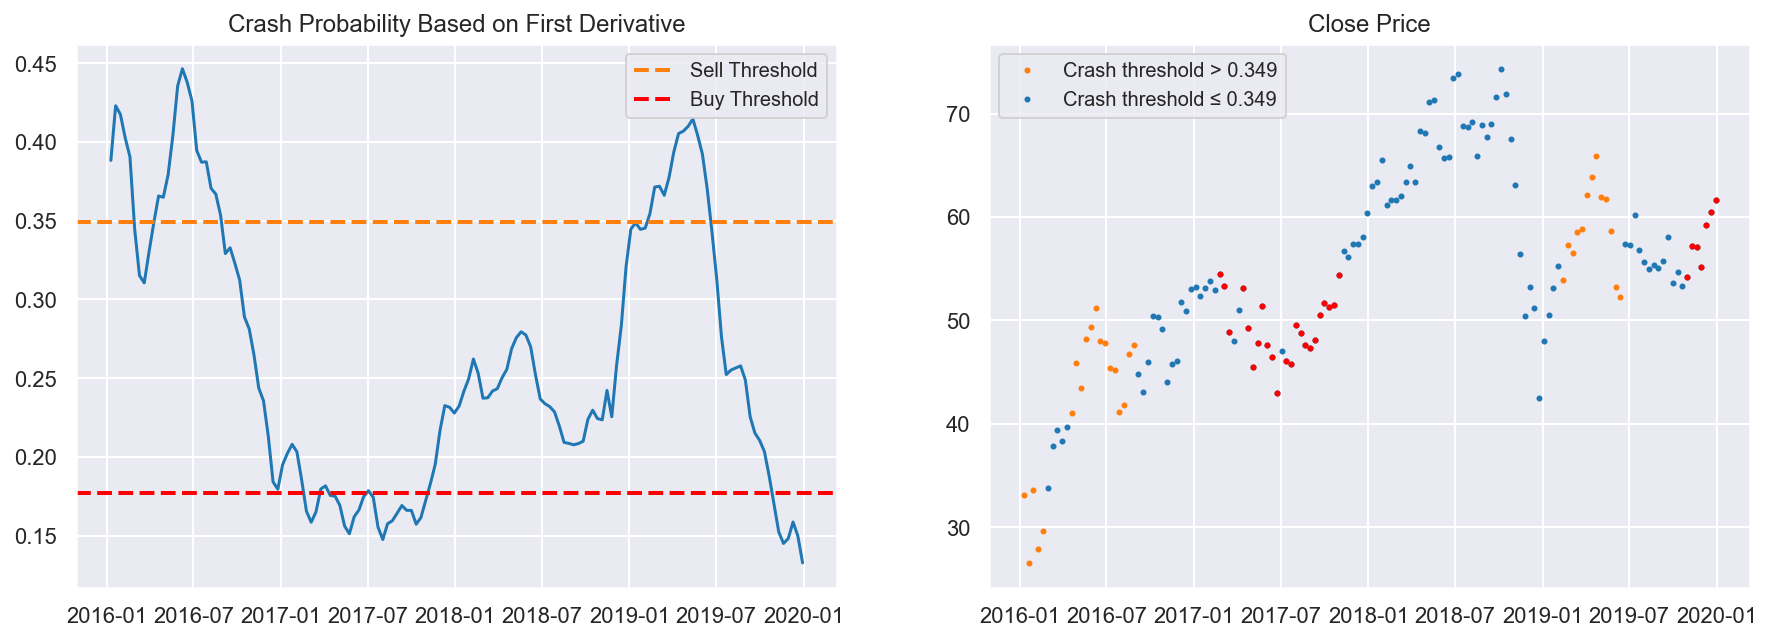

<Figure size 864x288 with 0 Axes>

In [19]:
plot_crash_detections_std(
    start_date="2016-01-01",
    end_date="2020-10-01",
    coefficient=1,
    distances=abs_derivative_of_means,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='First Derivative'
)

From the plot we see that the first derivative appears to give an indication of where crashes have happened in the past, albeit with quite some noise around each event.

## Persistence diagrams

The first step in a TDA pipeline typically involves calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. The horizontal axis corresponds to the moment in which a homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.

In [20]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=-1)
diagrams = VR.fit_transform(price_embedded_windows)

In the plot below for a single window, the generators of each homology dimension $H_0$ and $H_1$ are coloured differently:

In [21]:
VR.plot(diagrams, sample=window_num)

## Homological derivatives

Given a persistence diagram, there are a number of possible features that can derived from it. For our application, we are interested in calculating the distance between diagrams obtained from two successive windows. Although one can calculate this directly from the `PairwiseDistance` class, we show below how one can make use of `giotto-learn`'s API to create a custom transformer:

In [22]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import check_diagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):

        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])

        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)
            Xt = Xt.reshape(len(self.homology_dimensions_), len(X) - 1).T
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

### Landscape distances

With our transformer defined, let's use it to calculate the successive distance between diagrams using the landscape distance:

In [23]:
metric_params = {"p": 2, "n_layers": 10, "n_bins": 1000}

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=-1
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

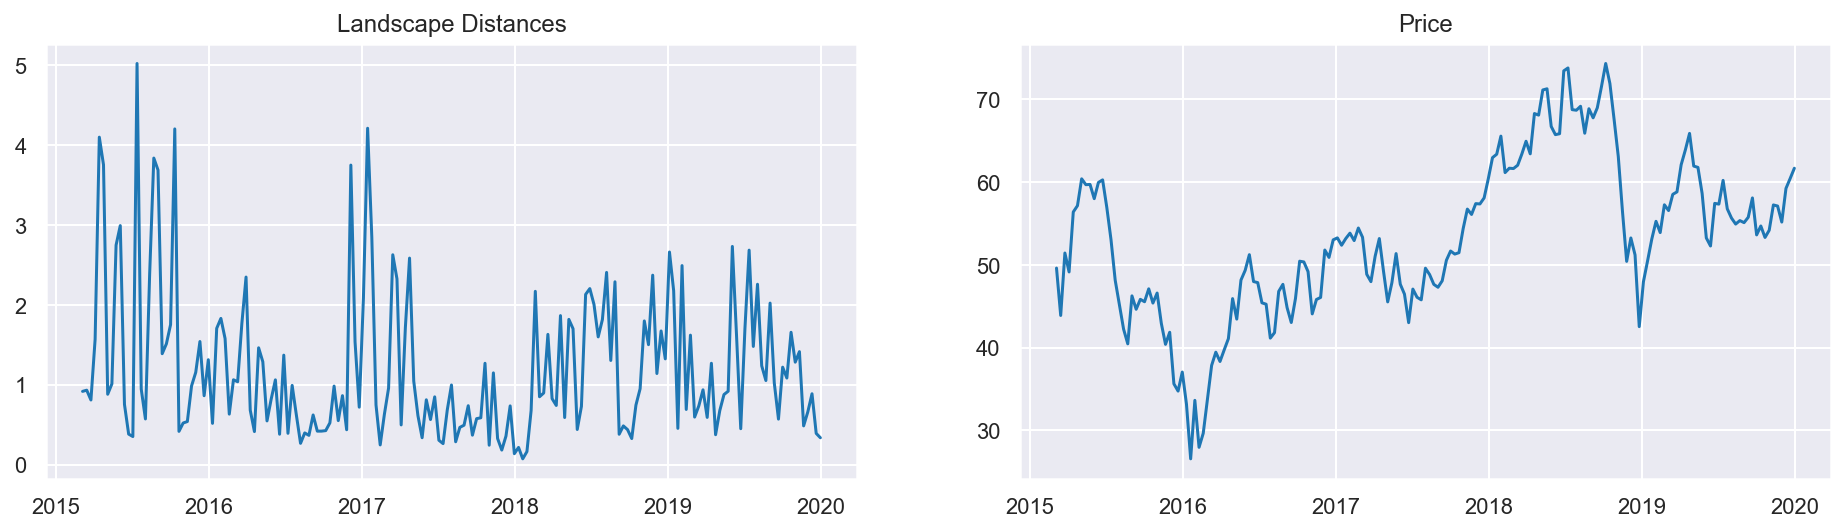

In [24]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances")

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs, "#1f77b4")
plt.title("Price")
plt.show()

## Distances among diagrams using Betti curves

In this section we show how to compute distances among persistece diagrams. There are many notions of distances: here we use the $l^p$ *norm of the Betti curves*.

In [25]:
metric_params = {"p": 2, "n_bins": 1000}


bettiHomDer = HomologicalDerivative(
    metric='betti', metric_params=metric_params, order=2, n_jobs=-1
)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

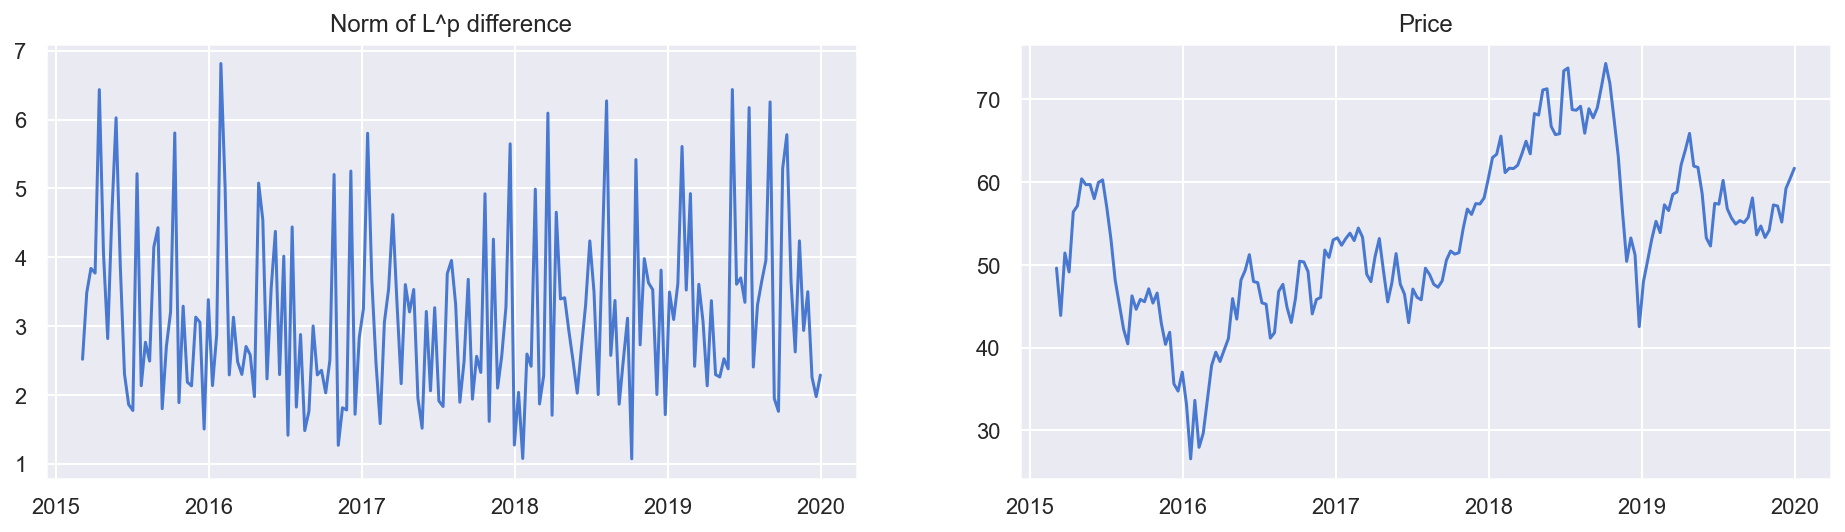

In [26]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

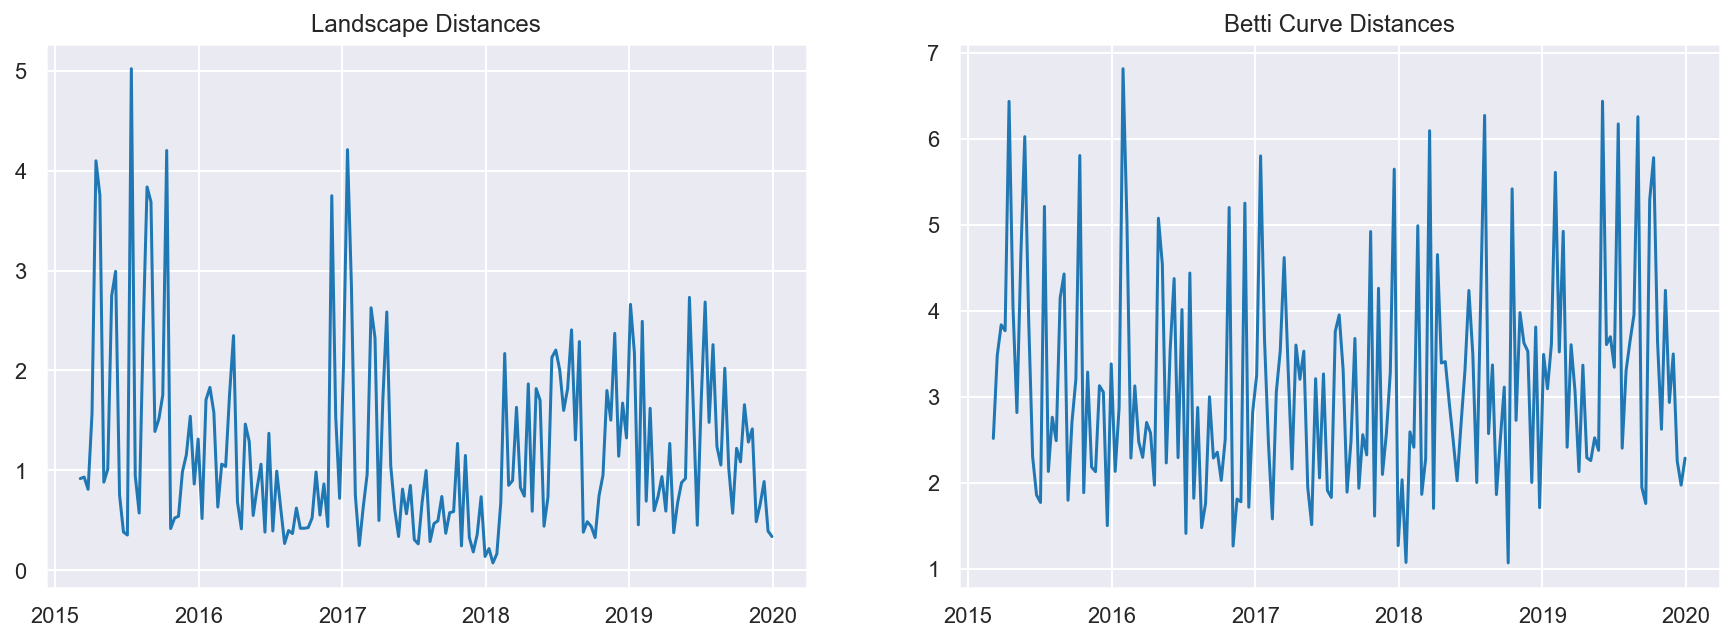

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances')
plt.show()

## Topological indicators for crashes
By comparing the different ways to measure change of topological signature, it seems that the landscape approach carries more information and is more robust to noise, let's investigate a bit more what is happening around selected market crashes using the landscape distance.

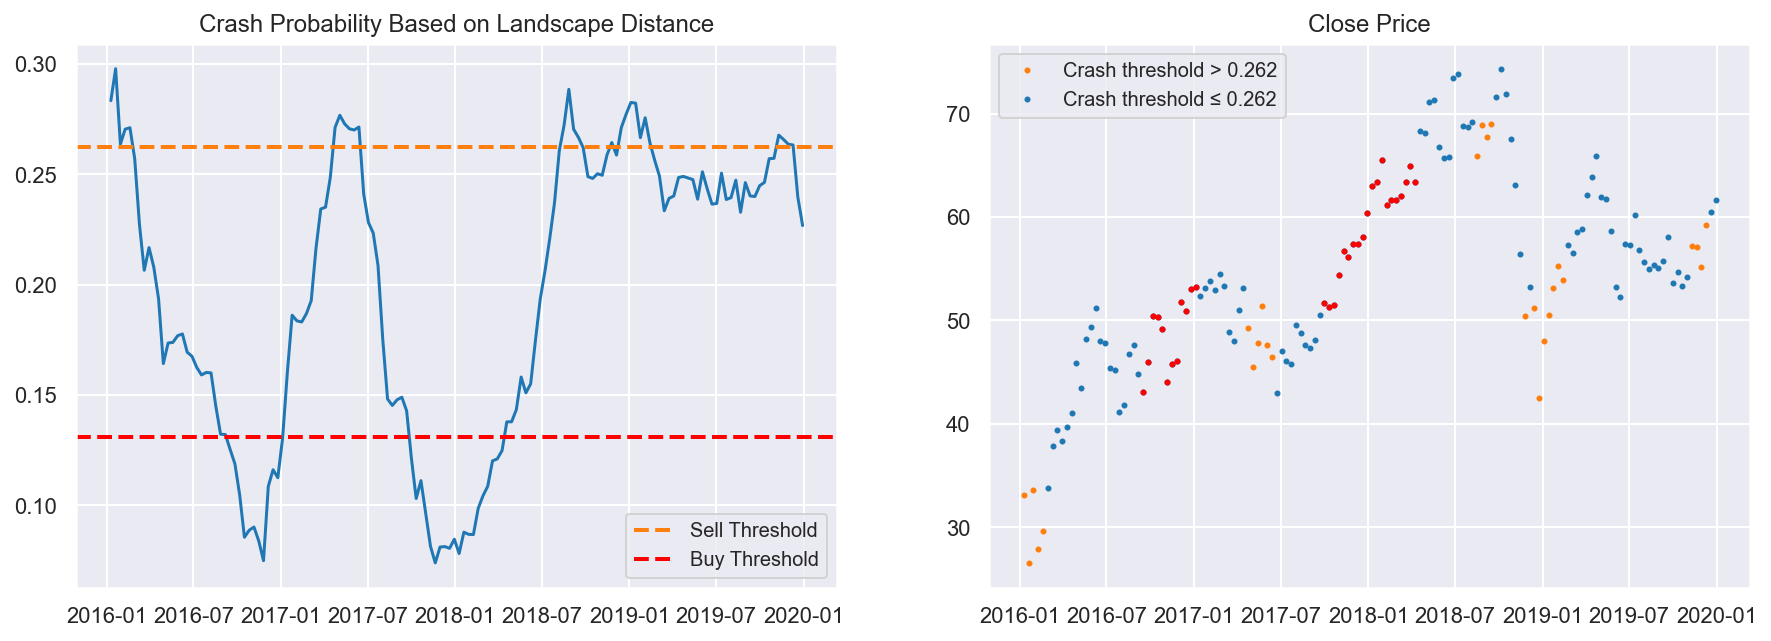

<Figure size 864x288 with 0 Axes>

In [28]:
plot_crash_detections_std(
    start_date="2016-01-01",
    end_date="2020-01-01",
    distances=landscape_succ_dists,
    coefficient=1,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

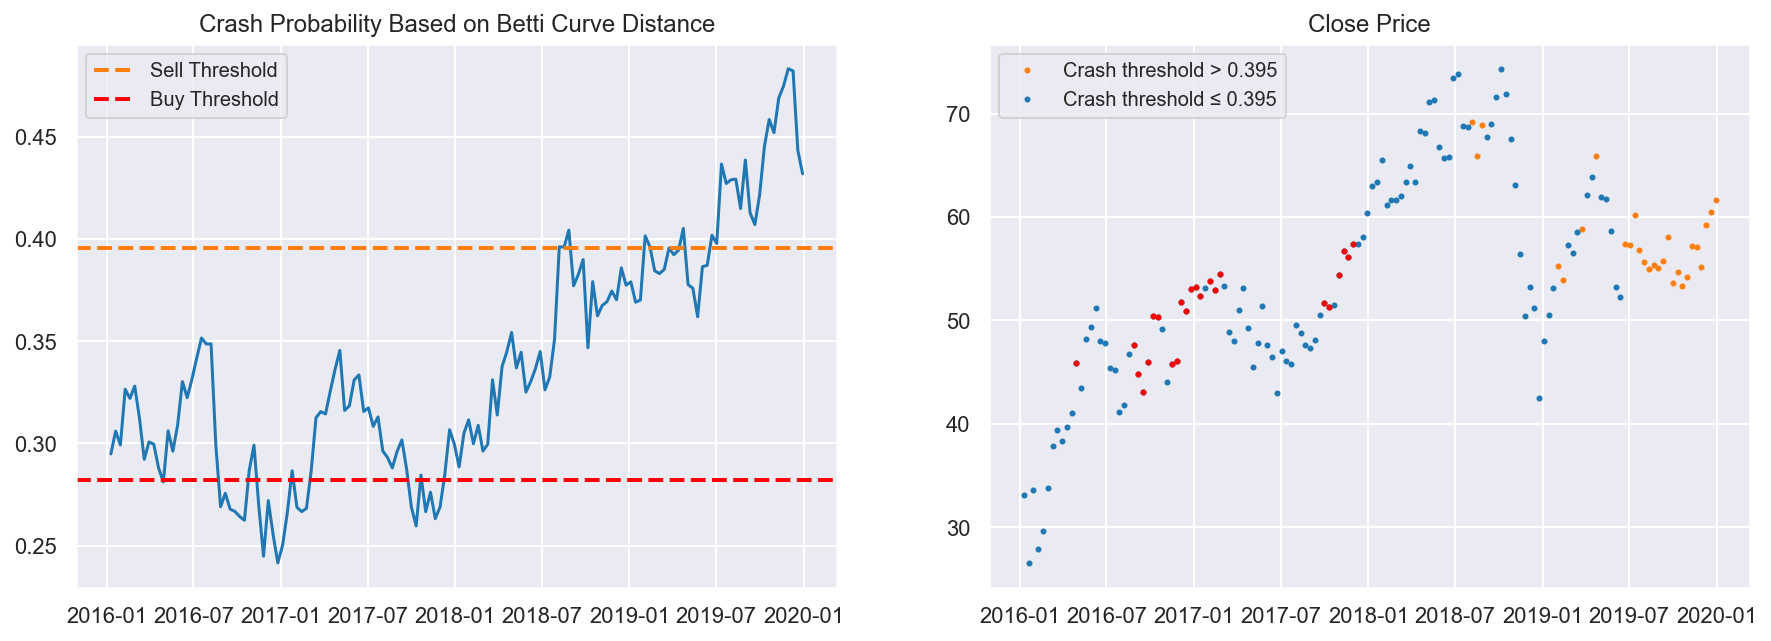

<Figure size 864x288 with 0 Axes>

In [29]:
plot_crash_detections_std(
    start_date="2016-01-01",
    end_date="2020-01-01",
    coefficient=1,
    distances=betti_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Betti Curve Distance'
)

It seems like the landscape distance does a much better job at predicting future market movement than the betti curvie distance does. The overall predicted crash probability for betti distances is, in general, a lot higher than that using the landscape distance so a head to head comparison doesn't make much sense. As a final comparison we show the difference between the baseline detector and the topological detector.

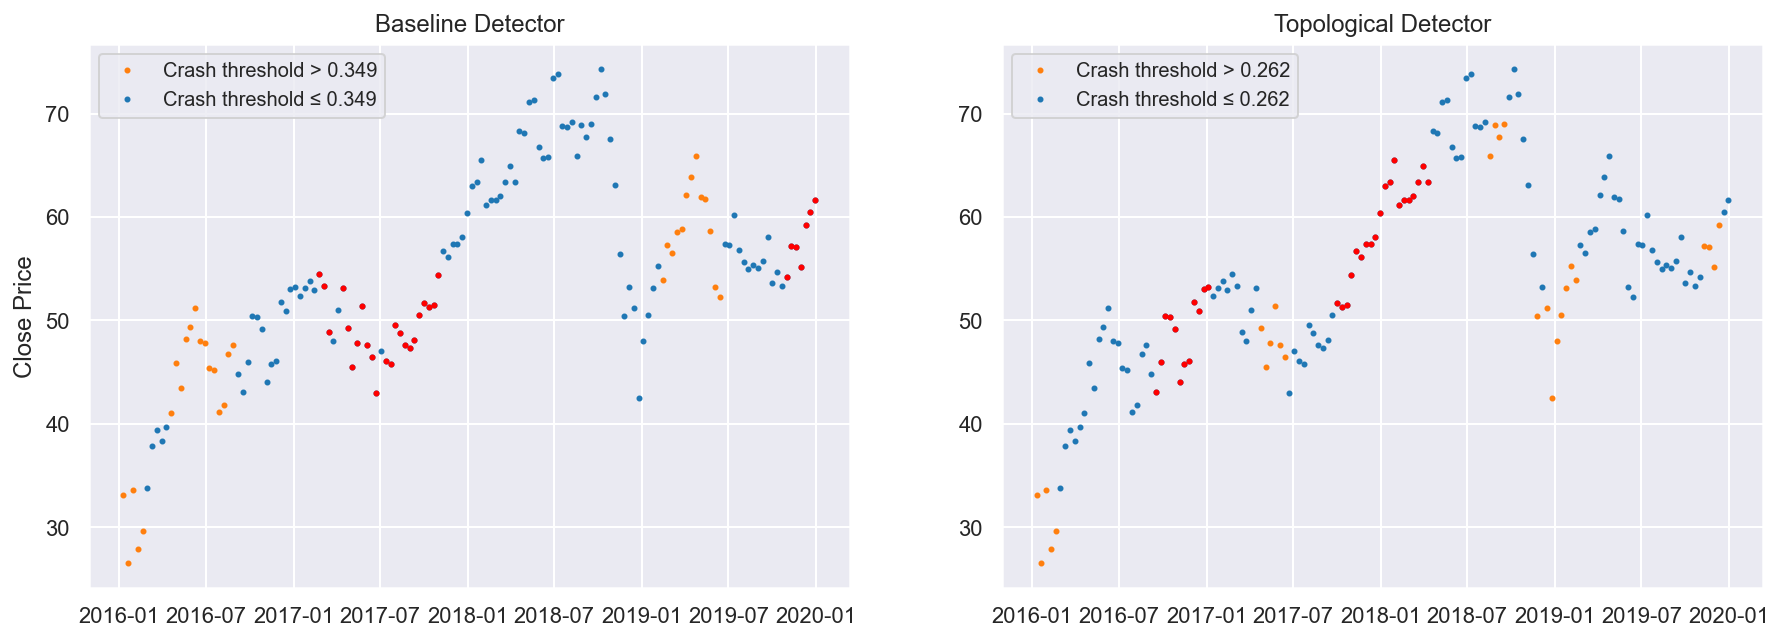

<Figure size 864x288 with 0 Axes>

In [30]:
plot_crash_comparisons_std(
    start_date="2016-01-01",
    end_date="2020-01-01",
    coefficient=1,
    distances_1=abs_derivative_of_means,
    distances_2=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
)